In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
import seaborn as sns
#Dataset Directory
training_dir = "Dataset/Dataset Kaggle/Training"
validation_dir = "Dataset/Dataset Kaggle/Validation"

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Image Normalization and Image Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      rotation_range=0.1,
      fill_mode='nearest'
    )

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(training_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size=32,
                                                              class_mode  = 'categorical',
                                                              target_size = (150, 150))

train_generator.class_indices

Found 3252 images belonging to 3 classes.
Found 804 images belonging to 3 classes.


{'Covid-19': 0, 'Normal': 1, 'Tuberculosis': 2}

# **Training first Model with my own architectur (Model C)**

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                    

In [4]:
#Learning Rate Scheduler
from tensorflow.keras.optimizers.schedules import PolynomialDecay

num_epochs = 100
num_train_steps = (train_generator.samples // 32) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0,
    decay_steps=num_train_steps
)

In [5]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=lr_scheduler), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks (optional)
# class MyCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if (logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
#       print('Good enough accuracy so cancelling training!')
#       self.model.stop_training = True

# callback = MyCallback()

#Training Proccess
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // 32,
    verbose = 2
    # callbacks=[callback]
)

Epoch 1/100
101/101 - 81s - loss: 0.9625 - accuracy: 0.5286 - val_loss: 0.8973 - val_accuracy: 0.6400 - 81s/epoch - 801ms/step
Epoch 2/100
101/101 - 29s - loss: 0.7216 - accuracy: 0.6969 - val_loss: 0.7427 - val_accuracy: 0.7638 - 29s/epoch - 289ms/step
Epoch 3/100
101/101 - 31s - loss: 0.6602 - accuracy: 0.7314 - val_loss: 0.6713 - val_accuracy: 0.7875 - 31s/epoch - 308ms/step
Epoch 4/100
101/101 - 40s - loss: 0.6206 - accuracy: 0.7556 - val_loss: 0.6155 - val_accuracy: 0.8175 - 40s/epoch - 394ms/step
Epoch 5/100
101/101 - 35s - loss: 0.5837 - accuracy: 0.7770 - val_loss: 0.5508 - val_accuracy: 0.8075 - 35s/epoch - 342ms/step
Epoch 6/100
101/101 - 40s - loss: 0.5728 - accuracy: 0.7870 - val_loss: 0.5522 - val_accuracy: 0.8263 - 40s/epoch - 399ms/step
Epoch 7/100
101/101 - 56s - loss: 0.5441 - accuracy: 0.8053 - val_loss: 0.5668 - val_accuracy: 0.7887 - 56s/epoch - 555ms/step
Epoch 8/100
101/101 - 44s - loss: 0.5549 - accuracy: 0.7941 - val_loss: 0.5421 - val_accuracy: 0.8325 - 44s/epo

Text(0.5, 1.0, 'Training and validation loss')

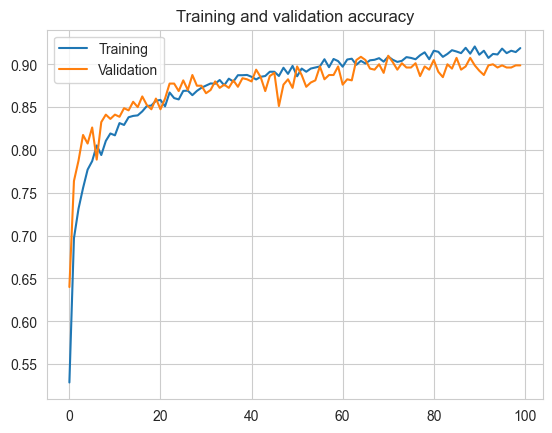

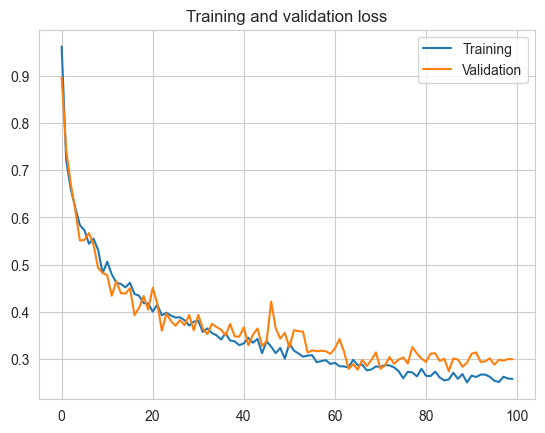

In [6]:
#Plotting the training results
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

# **Training second Model with Alexnet architectur (Model A)**

In [7]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(96, 11, strides=4, activation='relu', padding='same', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(3, strides=2),
    tf.keras.layers.Conv2D(256, 5, strides=4, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(3, strides=2),
    tf.keras.layers.Conv2D(384, 3, strides=4, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(384, 3, strides=4, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, 3, strides=4, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 38, 38, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 18, 96)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 256)         614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 256)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 1, 384)         885120    
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 1, 384)        

In [8]:
from tensorflow.keras.optimizers import Adam
model2.compile(optimizer=Adam(learning_rate=lr_scheduler), loss='categorical_crossentropy', metrics=['accuracy'])

#Training proccess
history2 = model2.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // 32,
    verbose = 2
    # callbacks=[callback]
)

Epoch 1/100
101/101 - 40s - loss: 0.9831 - accuracy: 0.5009 - val_loss: 0.8160 - val_accuracy: 0.5813 - 40s/epoch - 395ms/step
Epoch 2/100
101/101 - 31s - loss: 0.6829 - accuracy: 0.6882 - val_loss: 0.6952 - val_accuracy: 0.7113 - 31s/epoch - 311ms/step
Epoch 3/100
101/101 - 43s - loss: 0.5963 - accuracy: 0.7370 - val_loss: 0.5714 - val_accuracy: 0.7625 - 43s/epoch - 421ms/step
Epoch 4/100
101/101 - 45s - loss: 0.4857 - accuracy: 0.8081 - val_loss: 0.5420 - val_accuracy: 0.7837 - 45s/epoch - 449ms/step
Epoch 5/100
101/101 - 31s - loss: 0.4407 - accuracy: 0.8289 - val_loss: 0.4904 - val_accuracy: 0.8012 - 31s/epoch - 310ms/step
Epoch 6/100
101/101 - 31s - loss: 0.3815 - accuracy: 0.8658 - val_loss: 0.4389 - val_accuracy: 0.8375 - 31s/epoch - 312ms/step
Epoch 7/100
101/101 - 32s - loss: 0.3482 - accuracy: 0.8770 - val_loss: 0.3796 - val_accuracy: 0.8625 - 32s/epoch - 312ms/step
Epoch 8/100
101/101 - 35s - loss: 0.3759 - accuracy: 0.8581 - val_loss: 0.3716 - val_accuracy: 0.8600 - 35s/epo

Text(0.5, 1.0, 'Training and validation loss')

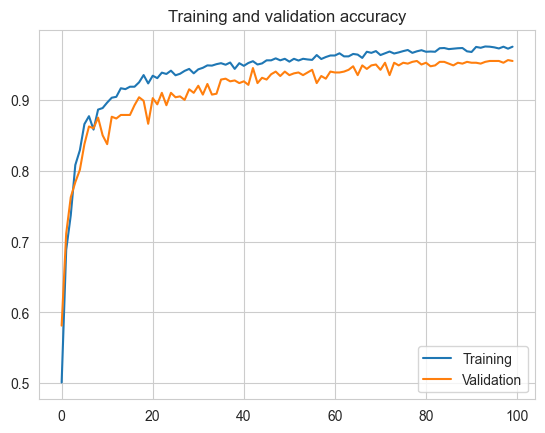

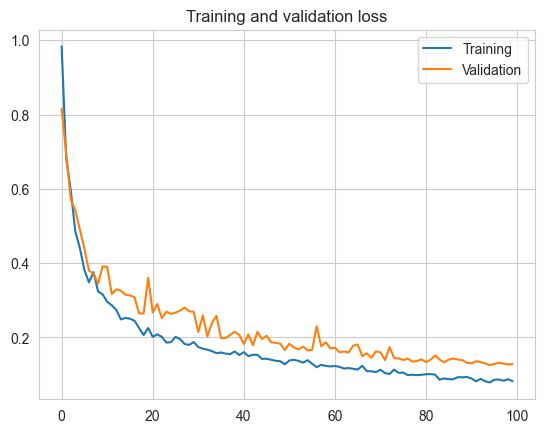

In [9]:
#Plotting the results of the second model
acc2      = history2.history[     'accuracy' ]
val_acc2  = history2.history[ 'val_accuracy' ]
loss2     = history2.history[    'loss' ]
val_loss2 = history2.history['val_loss' ]

epochs2   = range(len(acc2)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs2,     acc2, label='Training')
plt.plot  ( epochs2, val_acc2, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs2,     loss2, label='Training')
plt.plot  ( epochs2, val_loss2, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

# **LeNet Architecture (Model B)** 

In [10]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 146, 146, 6)       456       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 73, 6)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 73, 73, 6)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 69, 69, 16)        2416      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 34, 34, 16)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 34, 34, 16)       

In [11]:
from tensorflow.keras.optimizers import Adam
model3.compile(optimizer=Adam(learning_rate=lr_scheduler), loss='categorical_crossentropy', metrics=['accuracy'])

#Training proccess
history3 = model3.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // 32,
    verbose = 2
    # callbacks=[callback]
)

Epoch 1/100
101/101 - 33s - loss: 0.9970 - accuracy: 0.5016 - val_loss: 0.8945 - val_accuracy: 0.6700 - 33s/epoch - 331ms/step
Epoch 2/100
101/101 - 18s - loss: 0.7144 - accuracy: 0.7019 - val_loss: 0.6748 - val_accuracy: 0.7700 - 18s/epoch - 179ms/step
Epoch 3/100
101/101 - 18s - loss: 0.6341 - accuracy: 0.7503 - val_loss: 0.5880 - val_accuracy: 0.8125 - 18s/epoch - 183ms/step
Epoch 4/100
101/101 - 20s - loss: 0.5873 - accuracy: 0.7776 - val_loss: 0.5512 - val_accuracy: 0.8325 - 20s/epoch - 194ms/step
Epoch 5/100
101/101 - 19s - loss: 0.5619 - accuracy: 0.7829 - val_loss: 0.5106 - val_accuracy: 0.8413 - 19s/epoch - 192ms/step
Epoch 6/100
101/101 - 20s - loss: 0.5501 - accuracy: 0.7891 - val_loss: 0.5073 - val_accuracy: 0.8275 - 20s/epoch - 196ms/step
Epoch 7/100
101/101 - 20s - loss: 0.5463 - accuracy: 0.7960 - val_loss: 0.5017 - val_accuracy: 0.8375 - 20s/epoch - 198ms/step
Epoch 8/100
101/101 - 19s - loss: 0.5172 - accuracy: 0.8149 - val_loss: 0.4884 - val_accuracy: 0.8388 - 19s/epo

Text(0.5, 1.0, 'Training and validation loss')

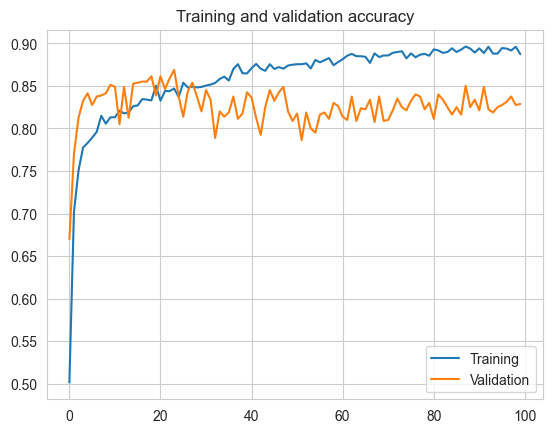

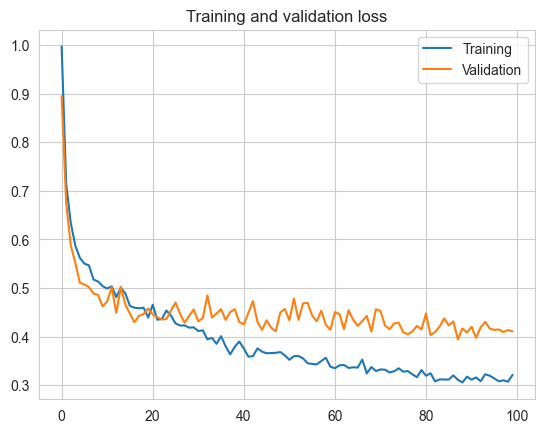

In [12]:
#Plotting the results of the third model
acc3      = history3.history[     'accuracy' ]
val_acc3  = history3.history[ 'val_accuracy' ]
loss3     = history3.history[    'loss' ]
val_loss3 = history3.history['val_loss' ]

epochs3   = range(len(acc3)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs3,     acc3, label='Training')
plt.plot  ( epochs3, val_acc3, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs3,     loss3, label='Training')
plt.plot  ( epochs3, val_loss3, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

# **Comparation**

<Figure size 640x480 with 0 Axes>

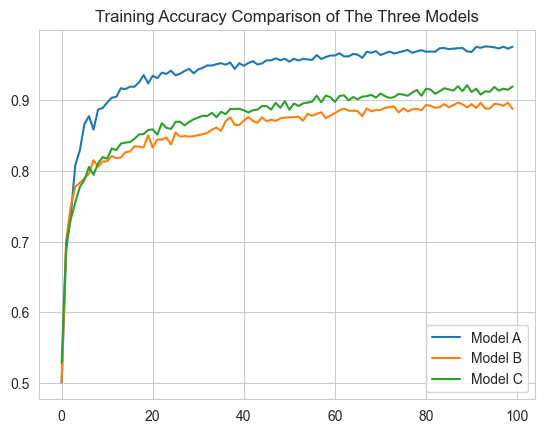

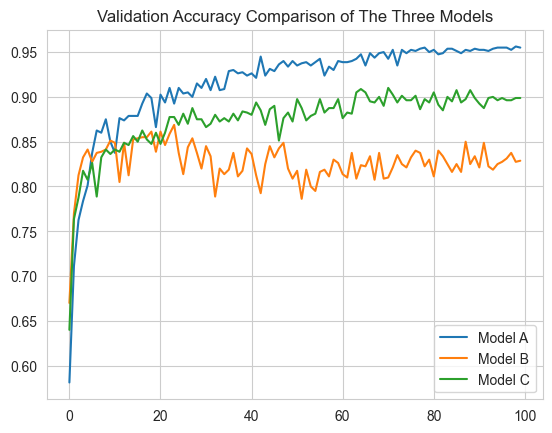

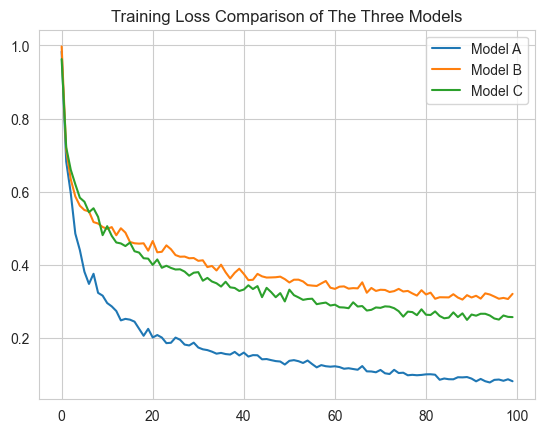

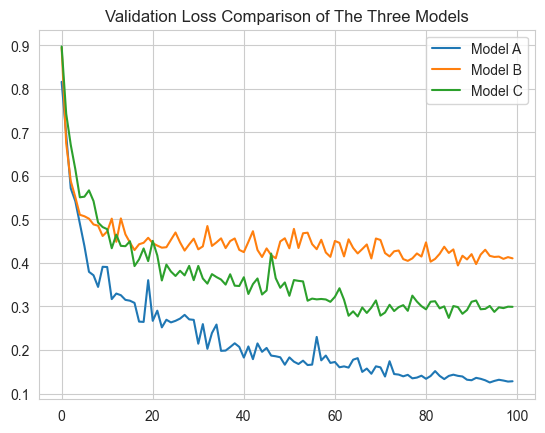

<Figure size 640x480 with 0 Axes>

In [13]:
#------------------------------------------------
# Plot training accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs2,     acc2, label='Model A')
plt.plot  ( epochs3,     acc3, label='Model B')
plt.plot  ( epochs,      acc,  label='Model C')
plt.title ('Training Accuracy Comparison of The Three Models')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs2,     val_acc2, label='Model A')
plt.plot  ( epochs3,     val_acc3, label='Model B')
plt.plot  ( epochs,      val_acc,  label='Model C')
plt.title ('Validation Accuracy Comparison of The Three Models')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training loss per epoch
#------------------------------------------------
plt.plot  ( epochs2,     loss2, label='Model A')
plt.plot  ( epochs3,     loss3, label='Model B')
plt.plot  ( epochs,      loss,  label='Model C')
plt.title ('Training Loss Comparison of The Three Models')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs2,     val_loss2, label='Model A')
plt.plot  ( epochs3,     val_loss3, label='Model B')
plt.plot  ( epochs,      val_loss,  label='Model C')
plt.title ('Validation Loss Comparison of The Three Models')
plt.legend()
plt.figure()

# **Save the the Models**

In [14]:
model.save("Model/Model Kaggle/model_C.h5")
model2.save("Model/Model Kaggle/model_A.h5")
model3.save("Model/Model Kaggle/model_B.h5")